# ASSIGNMENT #5 - UPPER AIR DATA #
Due: 08 April 2024 @ 11:59p

Purpose:\
The purpose of this assignment is to first collect data from an online archive using a user-created function.  The data is then plotted on a map to continue to familiarize with plotting weather data on maps.  

Overview:\
In this assignment you will read in rawinsonde observations in a function and plot that data.


| | UPDATE TO YOUR INFORMATION | 
| :- | :- |
| Created By | Devyn M. Kimball|
| Creation Date |3 April 2024 |
| Course | ATSC 270 - Computer Concepts in Meteorology |

In [39]:
### UPDATE TO YOUR INFORMATION ###
#information allowing anyone with the code to print the author and contact information
__author__    = "Devyn M. Kimball"
__contact__   = "Devyn.Kimball@und.edu"

### IMPORT REQUIRED LIBRARIES ###

In [40]:
import numpy as np
from datetime import datetime

from assignment_5_functions import get_raobs, select_press

import metpy.calc as mpcalc
from metpy.units import units
from metpy.plots import StationPlot
from metpy.interpolate import interpolate_to_grid, remove_nan_observations

import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

### DOWNLOAD OBSERVATIONS FROM  FILE ###
RAwinsonde OBservations (RAOBs) are available from the Iowa State Environmental Mesonet (IEM) archive.  This data can be accessed using the siphon module.  All this will be done within the assignment_5_functions file.  Note, RAOBs don't specify latitude/longitude so we need to add it using a metpy function -> *add_station_lat_lon(data)*.

In [41]:
#grab data from 00Z on 26 December 2023
dt = datetime(2023,12,26,0)

data = get_raobs(dt)

print(data)

       pressure   height  temperature  dewpoint  direction  speed station  \
0         979.0    386.0         -4.7      -5.4       15.0    2.0    CWPL   
1         968.0    476.0         -4.3      -7.2        NaN    NaN    CWPL   
2         952.0    606.0         -5.5      -7.6        NaN    NaN    CWPL   
3         951.6    609.0          NaN       NaN      355.0    5.0    CWPL   
4         947.0    647.0         -5.5      -8.8        NaN    NaN    CWPL   
...         ...      ...          ...       ...        ...    ...     ...   
14695       5.9  34574.0        -45.3     -84.3        NaN    NaN    KYXY   
14696       5.7  34747.0          NaN       NaN      145.0   15.0    KYXY   
14697       5.4  35159.0        -48.7     -86.7        NaN    NaN    KYXY   
14698       4.7  36076.0        -45.1     -85.1        NaN    NaN    KYXY   
14699       4.0  37145.0        -47.3     -86.3        NaN    NaN    KYXY   

            time    u_wind     v_wind  latitude  longitude  
0     2023-12-

### SUBSET TO 500MB OBS ###
We'll also do this within a function in the assignment_5_functions file.

In [42]:
data_500 = select_press(data,500)
print(data_500)

       pressure  height  temperature  dewpoint  direction  speed station  \
35        500.0  5630.0        -20.1     -52.1      280.0   16.0    CWPL   
177       500.0  5700.0        -20.1     -49.1      110.0    1.0    CWQI   
307       500.0  5620.0        -16.5     -24.5      325.0   25.0    CWSE   
451       500.0  5360.0        -20.9     -55.9      265.0  121.0    CYAH   
574       500.0  5340.0        -27.3     -30.8      315.0   49.0    CYBK   
...         ...     ...          ...       ...        ...    ...     ...   
14105     500.0  5850.0         -5.9     -11.9      250.0   27.0    KVER   
14169     500.0  5730.0        -16.3     -45.3      315.0   35.0    KWAL   
14291     500.0  5150.0        -26.1     -27.9      150.0   37.0    KYAK   
14451     500.0  5710.0        -15.5     -34.5      275.0   24.0    KYMW   
14573     500.0  5230.0        -24.7     -25.4      190.0   43.0    KYXY   

            time      u_wind     v_wind  latitude  longitude  
35    2023-12-26   15.75

### PLOT DATA MAP ###
Use the same map of CONUS as we did for the beginning of surface obs.<br>
No need to thin obs as there aren't a ton of RAOBs.

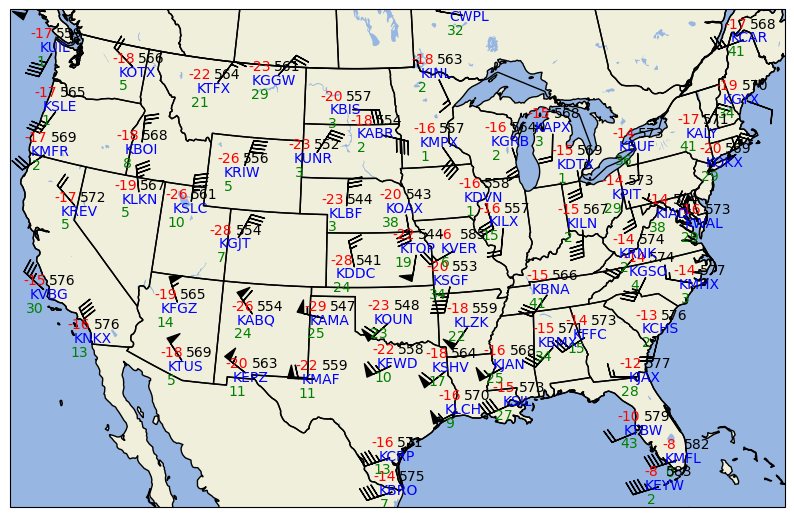

In [43]:
#we'll center the map at 100W,35N
proj = ccrs.LambertConformal(central_longitude=-100,central_latitude=35)

#create 10" x 10" figure with a dpi=100
fig = plt.figure(figsize=(10,10),dpi=100)
#add subplot with projection
ax = fig.add_subplot(1,1,1,projection=proj)

#add elements to make map more useable
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)

#create stationplot (will actually need to create 2 to handle wind gusts)
stationplot = StationPlot(ax,data_500['longitude'],data_500['latitude'],clip_on = True,transform=ccrs.PlateCarree())

#zoom on the CONUS
#lon_min = -120
#lon_max = -75
#lat_min = 23
#lat_max = 50
ax.set_extent((-120, -75, 23, 50))

#temperature in red
stationplot.plot_parameter('NW',data_500['temperature'].values, color='red')
#dewpoint DEPRESSION in dark green
stationplot.plot_parameter('SW',data_500['temperature'].values - data_500['dewpoint'].values, color='green')
#height (need to format to be the first 3 digits)
stationplot.plot_parameter('NE',data_500['height'].values/10)
#station ID in dark blue
stationplot.plot_text('C',data_500['station'].values, color='blue')
#wind in black
stationplot.plot_barb(data_500.u_wind, data_500.v_wind)
#save the map as upper_air_500.png
plt.savefig('upper_air_500.png')

### CREATE 500mb HEIGHT CONTOURS (ISOHYPSES) ###

In [44]:
#convert the data to x, y, and z locations on the projected map
x,y,z = proj.transform_points(ccrs.PlateCarree(), data_500['longitude'].values,data_500['latitude'].values).T
#remove nans
mask = ~np.isnan(x)
#interpolate the data to a grid
grdx,grdy,hght = interpolate_to_grid(x[mask],y[mask],data_500['height'].values[mask],
                                     interp_type='cressman',search_radius=1000000, minimum_neighbors=3,hres=100000)

### PLOT UPPER AIR STATION PLOTS & CONTOURS ###

[4600 4630 4660 4690 4720 4750 4780 4810 4840 4870 4900 4930 4960 4990
 5020 5050 5080 5110 5140 5170 5200 5230 5260 5290 5320 5350 5380 5410
 5440 5470 5500 5530 5560 5590 5620 5650 5680 5710 5740 5770 5800 5830
 5860 5890 5920 5950 5980]


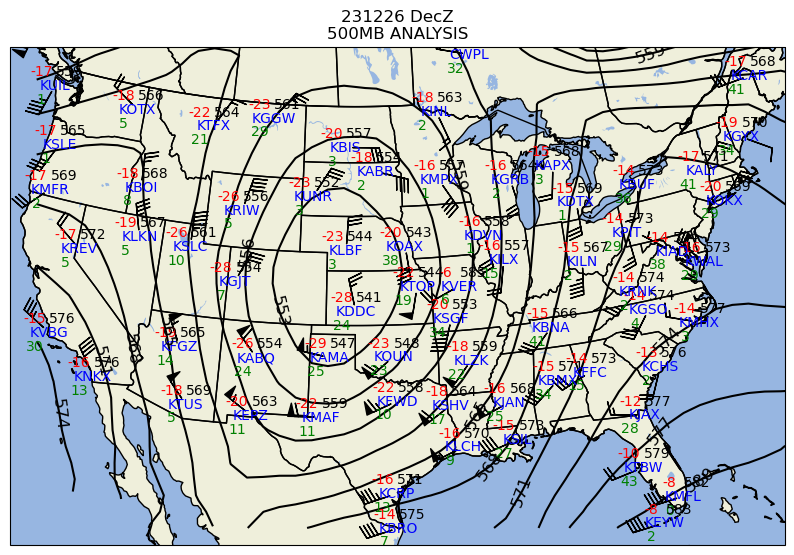

In [46]:
fig = plt.figure(figsize=(10,10),dpi=100)
#add subplot with projection
ax = fig.add_subplot(1,1,1,projection=proj)

#add elements to make map more useable
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)

#create stationplot (will actually need to create 2 to handle wind gusts)
stationplot = StationPlot(ax,data_500['longitude'],data_500['latitude'],clip_on = True,transform=ccrs.PlateCarree())

#zoom on the CONUS
#lon_min = -120
#lon_max = -75
#lat_min = 23
#lat_max = 50
ax.set_extent((-120, -75, 23, 50))

#temperature in red
stationplot.plot_parameter('NW',data_500['temperature'].values, color='red')
#dewpoint DEPRESSION in dark green
stationplot.plot_parameter('SW',data_500['temperature'].values - data_500['dewpoint'].values, color='green')
#height (need to format to be the first 3 digits)
stationplot.plot_parameter('NE',data_500['height'].values/10)
#station ID in dark blue
stationplot.plot_text('C',data_500['station'].values, color='blue')
#wind in black
stationplot.plot_barb(data_500.u_wind, data_500.v_wind)
#plot contours from 4600m to 6000m with 60m interval
clevs = np.arange(4600,6000,30)
print(clevs)
cs = ax.contour(grdx,grdy,hght,clevs,colors='black')
ax.clabel(cs,inline=True,fmt=lambda v: format(v, '.0f')[:3],fontsize=12)
#add a title with the date
plt.title(f'{dt.strftime("%y%m%d %hZ")}\n500MB ANALYSIS')

#save the map as contour_500.png
plt.savefig('contour_500.png')